## MTA Project - Data Cleaning and Visualization

### Get Data from Website

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [211009,211002,210925,210918,210911,210904,210828,210821,210814,210807,210731,210724,210717,210710,210703,
            210626,210619,210612,210605,210529,210522,210515,210508,210501,210424,210417,210410,210403]
turnstiles_df = get_data(week_nums)

In [3]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/02/2021,00:00:00,REGULAR,7645319,2616859
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/02/2021,04:00:00,REGULAR,7645333,2616861
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/02/2021,08:00:00,REGULAR,7645340,2616876
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/02/2021,12:00:00,REGULAR,7645385,2616906
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/02/2021,16:00:00,REGULAR,7645518,2616946


### Change DATE and TIME to a new column of datetime data type DATE_TIME

In [4]:
# Take the date and time fields into a single datetime column
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/02/2021,00:00:00,REGULAR,7645319,2616859,2021-10-02 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/02/2021,04:00:00,REGULAR,7645333,2616861,2021-10-02 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/02/2021,08:00:00,REGULAR,7645340,2616876,2021-10-02 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/02/2021,12:00:00,REGULAR,7645385,2616906,2021-10-02 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/02/2021,16:00:00,REGULAR,7645518,2616946,2021-10-02 16:00:00


### Get rid of the duplicate entry and drop EXIT AND DESC columns which are not useful

In [5]:
# Get rid of the duplicate entry
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)
turnstiles_df["WEEKDAY"] = turnstiles_df["DATE_TIME"].dt.dayofweek

In [6]:
# Drop Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")

### Calculate Daily_Entries

In [7]:
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,03/27/2021,7550517
1,A002,R051,02-00-00,59 ST,03/28/2021,7550675
2,A002,R051,02-00-00,59 ST,03/29/2021,7551178
3,A002,R051,02-00-00,59 ST,03/30/2021,7551731
4,A002,R051,02-00-00,59 ST,03/31/2021,7552051


In [8]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

/tmp/ipykernel_33824/4241375361.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [9]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,03/27/2021,7550517,NaN,NaN
1,A002,R051,02-00-00,59 ST,03/28/2021,7550675,03/27/2021,7550517.0
2,A002,R051,02-00-00,59 ST,03/29/2021,7551178,03/28/2021,7550675.0
3,A002,R051,02-00-00,59 ST,03/30/2021,7551731,03/29/2021,7551178.0
4,A002,R051,02-00-00,59 ST,03/31/2021,7552051,03/30/2021,7551731.0


In [10]:
# Drop the rows for the earliest date in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [11]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,03/28/2021,7550675,03/27/2021,7550517.0
2,A002,R051,02-00-00,59 ST,03/29/2021,7551178,03/28/2021,7550675.0
3,A002,R051,02-00-00,59 ST,03/30/2021,7551731,03/29/2021,7551178.0
4,A002,R051,02-00-00,59 ST,03/31/2021,7552051,03/30/2021,7551731.0
5,A002,R051,02-00-00,59 ST,04/01/2021,7552051,03/31/2021,7552051.0


In [12]:
turnstiles_daily['DAILY_ENTRIES'] = turnstiles_daily.apply(lambda x:abs(x['ENTRIES']-x['PREV_ENTRIES']),axis = 1)
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,03/28/2021,7550675,03/27/2021,7550517.0,158.0
2,A002,R051,02-00-00,59 ST,03/29/2021,7551178,03/28/2021,7550675.0,503.0
3,A002,R051,02-00-00,59 ST,03/30/2021,7551731,03/29/2021,7551178.0,553.0
4,A002,R051,02-00-00,59 ST,03/31/2021,7552051,03/30/2021,7551731.0,320.0
5,A002,R051,02-00-00,59 ST,04/01/2021,7552051,03/31/2021,7552051.0,0.0


In [13]:
station_daily = turnstiles_daily.groupby(["STATION"])[['DAILY_ENTRIES']].sum().sort_values('DAILY_ENTRIES', ascending=False).reset_index()
station_daily.rename(columns = {"DAILY_ENTRIES":"TOTAL_ENTRIES_2021"})
station_daily.head()
plot_data1 = station_daily.head(10)
plot_data1.head()

,STATION,DAILY_ENTRIES
0,FULTON ST,3.699831e+09
1,AQUEDUCT RACETR,3.338203e+09
2,HUNTS POINT AV,3.148098e+09
3,161/YANKEE STAD,2.170249e+09
4,HEWES ST,2.139226e+09


### Calculate Moment_Entries

In [14]:
turnstiles_moment = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME","TIME"],as_index=False)
                        .ENTRIES.first())
turnstiles_moment.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-03-27 00:00:00,00:00:00,7550517
1,A002,R051,02-00-00,59 ST,2021-03-27 04:00:00,04:00:00,7550517
2,A002,R051,02-00-00,59 ST,2021-03-27 08:00:00,08:00:00,7550517
3,A002,R051,02-00-00,59 ST,2021-03-27 12:00:00,12:00:00,7550517
4,A002,R051,02-00-00,59 ST,2021-03-27 16:00:00,16:00:00,7550517


In [15]:
turnstiles_moment[["PREV_DATE_TIME", "PREV_MOMENT_ENTRIES"]] = (turnstiles_moment
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE_TIME", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

/tmp/ipykernel_33824/341180055.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_moment[["PREV_DATE_TIME", "PREV_MOMENT_ENTRIES"]] = (turnstiles_moment


In [16]:
turnstiles_moment.dropna(subset=["PREV_DATE_TIME"], axis=0, inplace=True)
turnstiles_moment.head()
turnstiles_moment['MOMENT_ENTRIES'] = turnstiles_moment.apply(lambda x:abs(x['ENTRIES']-x['PREV_MOMENT_ENTRIES']),axis = 1)
turnstiles_moment.head()


,C/A,UNIT,SCP,STATION,DATE_TIME,TIME,ENTRIES,PREV_DATE_TIME,PREV_MOMENT_ENTRIES,MOMENT_ENTRIES
1,A002,R051,02-00-00,59 ST,2021-03-27 04:00:00,04:00:00,7550517,2021-03-27 00:00:00,7550517.0,0.0
2,A002,R051,02-00-00,59 ST,2021-03-27 08:00:00,08:00:00,7550517,2021-03-27 04:00:00,7550517.0,0.0
3,A002,R051,02-00-00,59 ST,2021-03-27 12:00:00,12:00:00,7550517,2021-03-27 08:00:00,7550517.0,0.0
4,A002,R051,02-00-00,59 ST,2021-03-27 16:00:00,16:00:00,7550517,2021-03-27 12:00:00,7550517.0,0.0
5,A002,R051,02-00-00,59 ST,2021-03-27 20:00:00,20:00:00,7550517,2021-03-27 16:00:00,7550517.0,0.0


In [17]:
turnstiles_block = turnstiles_moment
turnstiles_block["HOURS"] = turnstiles_block["DATE_TIME"].dt.hour

,C/A,UNIT,SCP,STATION,DATE_TIME,TIME,ENTRIES,PREV_DATE_TIME,PREV_MOMENT_ENTRIES,MOMENT_ENTRIES,HOURS
1,A002,R051,02-00-00,59 ST,2021-03-27 04:00:00,04:00:00,7550517,2021-03-27 00:00:00,7550517.0,0.0,4
2,A002,R051,02-00-00,59 ST,2021-03-27 08:00:00,08:00:00,7550517,2021-03-27 04:00:00,7550517.0,0.0,8
3,A002,R051,02-00-00,59 ST,2021-03-27 12:00:00,12:00:00,7550517,2021-03-27 08:00:00,7550517.0,0.0,12
4,A002,R051,02-00-00,59 ST,2021-03-27 16:00:00,16:00:00,7550517,2021-03-27 12:00:00,7550517.0,0.0,16
5,A002,R051,02-00-00,59 ST,2021-03-27 20:00:00,20:00:00,7550517,2021-03-27 16:00:00,7550517.0,0.0,20
...,...,...,...,...,...,...,...,...,...,...,...
5864727,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-10-08 05:00:00,05:00:00,5554,2021-10-08 01:00:00,5554.0,0.0,5
5864728,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-10-08 09:00:00,09:00:00,5554,2021-10-08 05:00:00,5554.0,0.0,9
5864729,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-10-08 13:00:00,13:00:00,5554,2021-10-08 09:00:00,5554.0,0.0,13
5864730,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-10-08 17:00:00,17:00:00,5554,2021-10-08 13:00:00,5554.0,0.0,17


In [47]:
total_moment = turnstiles_block.groupby(["HOURS"])[['MOMENT_ENTRIES']].sum().sort_values('MOMENT_ENTRIES', ascending=False).reset_index()
#station_moment.rename(columns = {"DAILY_ENTRIES":"YEARLY_ENTRIES"})
total_moment.head(15)
plot_data2 = total_moment.head(15)
plot_data2
all_moment1 = plot_data2.sort_values('MOMENT_ENTRIES', ascending=False).reset_index().head(10)
all_moment1.head(10)
all_moment = all_moment1.sort_values("HOURS").reset_index()
all_moment.head(50)


,level_0,index,HOURS,MOMENT_ENTRIES
0,8,8,4,1.625649e+08
1,9,9,8,9.764788e+07
2,6,6,9,7.839267e+08
3,0,0,12,8.031312e+09
4,1,1,13,7.323226e+09
5,5,5,14,1.340775e+09
6,3,3,16,5.796223e+09
7,2,2,17,6.214795e+09
8,4,4,20,2.591380e+09
9,7,7,21,2.320082e+08


### Find entry for top 10 TIME at each of the top 10 stations

In [69]:
station_daily.STATION[0]
total_moment.HOURS[0]
Two_D_array = np.zeros((10,10))
station_name_array = []
for i in range(10):
    time_station = turnstiles_block[turnstiles_block["STATION"]==station_daily.STATION[i]]
    station_name_array.append(station_daily.STATION[i])
    for j in range(10):
        time_station2 = time_station[time_station["HOURS"]==total_moment.HOURS[j]]
        sum_time = time_station2[["MOMENT_ENTRIES"]].sum()
        Two_D_array[i,j]=sum_time
Two_D_array


time_df = pd.DataFrame(station_name_array,columns = ["STATION_NAME"])
for i in range(10):
    time_df[total_moment.HOURS[i]] = Two_D_array[:,i]

time_df

,STATION_NAME,12,13,17,16,20,14,9,21,4,8
0,FULTON ST,3.905910e+05,2.037904e+09,1.650645e+09,5.750770e+05,1.290450e+05,0.0,443080.0,835804.0,6848.0,38890.0
1,AQUEDUCT RACETR,3.271306e+09,0.000000e+00,0.000000e+00,6.681128e+07,4.143800e+04,0.0,0.0,0.0,8224.0,8981.0
2,HUNTS POINT AV,0.000000e+00,2.204229e+09,9.434222e+08,0.000000e+00,8.000000e+02,0.0,264707.0,127152.0,0.0,0.0
3,161/YANKEE STAD,2.185850e+09,0.000000e+00,4.140000e+02,4.626080e+05,6.438536e+06,0.0,580.0,0.0,23483.0,391497.0
4,HEWES ST,0.000000e+00,4.311600e+04,2.139072e+09,0.000000e+00,0.000000e+00,0.0,37346.0,53474.0,0.0,0.0
5,CANARSIE-ROCKAW,0.000000e+00,1.560600e+09,5.838860e+05,0.000000e+00,0.000000e+00,0.0,198310.0,95078.0,0.0,1434.0
6,KINGS HWY,1.008485e+06,1.580650e+05,1.359460e+05,1.539503e+09,3.368020e+05,0.0,262757.0,96124.0,5508.0,294008.0
7,FLATBUSH AV-B.C,0.000000e+00,2.636890e+05,1.383404e+09,0.000000e+00,1.450000e+03,0.0,433953.0,201603.0,0.0,1447.0
8,90 ST-ELMHURST,1.185712e+09,0.000000e+00,0.000000e+00,3.339570e+05,2.629110e+05,0.0,1013.0,0.0,14561.0,451429.0
9,59 ST,6.548320e+05,2.720000e+02,0.000000e+00,7.317696e+06,1.042489e+09,354.0,0.0,0.0,68076.0,349253.0


In [72]:
#total_moment.head()
aaa = turnstiles_block.groupby(["HOURS","STATION"])[['MOMENT_ENTRIES']].sum().sort_values('MOMENT_ENTRIES', ascending=False).reset_index()
aaa[aaa["STATION"] == "AQUEDUCT RACETR"]

,HOURS,STATION,MOMENT_ENTRIES
0,12,AQUEDUCT RACETR,3.271306e+09
32,16,AQUEDUCT RACETR,6.681128e+07
1800,20,AQUEDUCT RACETR,4.143800e+04
2042,0,AQUEDUCT RACETR,2.693800e+04
2454,8,AQUEDUCT RACETR,8.981000e+03
2485,4,AQUEDUCT RACETR,8.224000e+03


### Find the ENTRY differences percentage in WEEKEND/WEEKDAY for the top 10 stations

In [23]:
weekday_or_not = turnstiles_daily
weekday_or_not["NEW_DATE_TIME"] = pd.to_datetime(weekday_or_not.DATE,format="%m/%d/%Y")
weekday_or_not["WEEKDAY"] = weekday_or_not["NEW_DATE_TIME"].dt.dayofweek
weekday_or_not["IS_WEEKDAY"] = weekday_or_not["WEEKDAY"]<5
weekday_or_not.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,NEW_DATE_TIME,WEEKDAY,IS_WEEKDAY
1,A002,R051,02-00-00,59 ST,03/28/2021,7550675,03/27/2021,7550517.0,158.0,2021-03-28,6,False
2,A002,R051,02-00-00,59 ST,03/29/2021,7551178,03/28/2021,7550675.0,503.0,2021-03-29,0,True
3,A002,R051,02-00-00,59 ST,03/30/2021,7551731,03/29/2021,7551178.0,553.0,2021-03-30,1,True
4,A002,R051,02-00-00,59 ST,03/31/2021,7552051,03/30/2021,7551731.0,320.0,2021-03-31,2,True
5,A002,R051,02-00-00,59 ST,04/01/2021,7552051,03/31/2021,7552051.0,0.0,2021-04-01,3,True


In [24]:
ratio_array = []
for i in range(10):
    station_mid = weekday_or_not[weekday_or_not["STATION"]==station_daily.STATION[i]]
    station_mid
    station_weekday = station_mid.groupby("IS_WEEKDAY")["DAILY_ENTRIES"].sum()
    weekday_ratio = ((station_weekday[True])/(station_weekday[True]+station_weekday[False]))*100
    ratio_array.append(weekday_ratio)
ratio_array
plot_data4 = pd.DataFrame(station_name_array,columns = ["STATION_NAME"])
plot_data4["WEEKDAY_RATIO"] = ratio_array
plot_data4

,STATION_NAME,WEEKDAY_RATIO
0,FULTON ST,99.606773
1,AQUEDUCT RACETR,50.005638
2,HUNTS POINT AV,98.464988
3,161/YANKEE STAD,74.270067
4,HEWES ST,99.997879
5,CANARSIE-ROCKAW,99.965204
6,KINGS HWY,15.031370
7,FLATBUSH AV-B.C,99.985096
8,90 ST-ELMHURST,99.971565
9,59 ST,99.911411


### Find the ENTRY differences percentage in HOT/COLD seasons for the top 10 stations

In [25]:
warm_or_not = turnstiles_daily
warm_or_not["NEW_DATE_TIME"] = pd.to_datetime(warm_or_not.DATE,format="%m/%d/%Y")
warm_or_not['month'] = pd.DatetimeIndex(warm_or_not['NEW_DATE_TIME']).month
warm_or_not["IS_WARM_SEASON"] = (warm_or_not["month"]>=6)&(warm_or_not["month"]<=9) 
warm_or_not.head(20)

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,NEW_DATE_TIME,WEEKDAY,IS_WEEKDAY,month,IS_WARM_SEASON
1,A002,R051,02-00-00,59 ST,03/28/2021,7550675,03/27/2021,7550517.0,158.0,2021-03-28,6,False,3,False
2,A002,R051,02-00-00,59 ST,03/29/2021,7551178,03/28/2021,7550675.0,503.0,2021-03-29,0,True,3,False
3,A002,R051,02-00-00,59 ST,03/30/2021,7551731,03/29/2021,7551178.0,553.0,2021-03-30,1,True,3,False
4,A002,R051,02-00-00,59 ST,03/31/2021,7552051,03/30/2021,7551731.0,320.0,2021-03-31,2,True,3,False
5,A002,R051,02-00-00,59 ST,04/01/2021,7552051,03/31/2021,7552051.0,0.0,2021-04-01,3,True,4,False
6,A002,R051,02-00-00,59 ST,04/02/2021,7552051,04/01/2021,7552051.0,0.0,2021-04-02,4,True,4,False
7,A002,R051,02-00-00,59 ST,04/03/2021,7552051,04/02/2021,7552051.0,0.0,2021-04-03,5,False,4,False
8,A002,R051,02-00-00,59 ST,04/04/2021,7552051,04/03/2021,7552051.0,0.0,2021-04-04,6,False,4,False
9,A002,R051,02-00-00,59 ST,04/05/2021,7552462,04/04/2021,7552051.0,411.0,2021-04-05,0,True,4,False
10,A002,R051,02-00-00,59 ST,04/06/2021,7552924,04/05/2021,7552462.0,462.0,2021-04-06,1,True,4,False


In [26]:
Two_D_array_season = np.zeros((20,1))
station_name_array_season = []
season_for_station_warm = []
season_for_station_cold = []
for i in range(10):
    season_station = warm_or_not[warm_or_not["STATION"]==station_daily.STATION[i]]
    station_name_array_season.append(station_daily.STATION[i])
    sum_time_season = season_station.groupby("IS_WARM_SEASON")["DAILY_ENTRIES"].sum()
    Two_D_array_season[i,0]=sum_time_season[True]
    Two_D_array_season[i+10,0]=sum_time_season[False]
    season_for_station_warm.append("WARM_SEASON")
    season_for_station_cold.append("COLD_SEASON")
Two_D_array_season
station_name_array_season+=station_name_array_season
season_for_station_warm+=season_for_station_cold
season_df = pd.DataFrame(station_name_array_season,columns = ["STATION_NAME"])
season_df["SEASON"] = season_for_station_warm
season_df["ENTRIES"] = Two_D_array_season[:,0]
season_df.head(20)

,STATION_NAME,SEASON,ENTRIES
0,FULTON ST,WARM_SEASON,6.665550e+06
1,AQUEDUCT RACETR,WARM_SEASON,2.010765e+08
2,HUNTS POINT AV,WARM_SEASON,9.919030e+08
3,161/YANKEE STAD,WARM_SEASON,5.646385e+08
4,HEWES ST,WARM_SEASON,1.364030e+05
5,CANARSIE-ROCKAW,WARM_SEASON,8.546120e+05
6,KINGS HWY,WARM_SEASON,1.359540e+06
7,FLATBUSH AV-B.C,WARM_SEASON,1.383922e+09
8,90 ST-ELMHURST,WARM_SEASON,1.186294e+09
9,59 ST,WARM_SEASON,1.049855e+09


### Plot Results

Text(0.5, 1.0, 'TOP 10 STATION OF TOTAL ENTRIES FROM APRIL TO OCTOBER 2021')

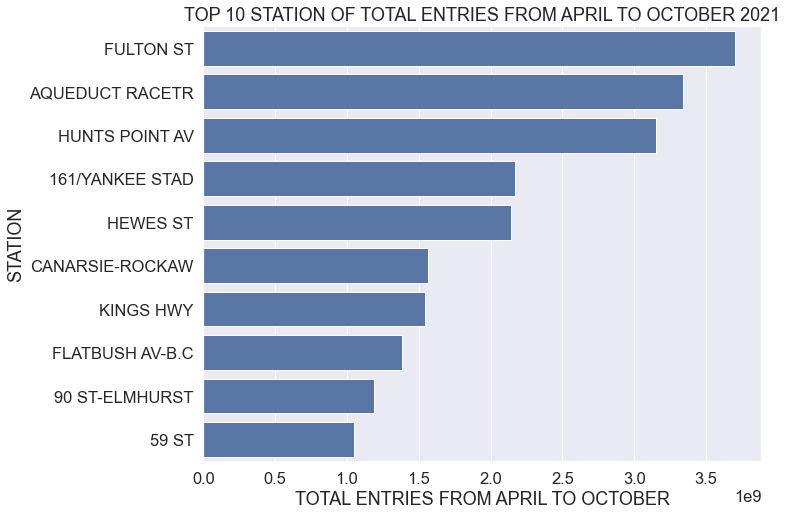

In [27]:
## Plot Results #1
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(10,8)})
sns.set(font_scale = 1.5)
seaborn_plot = sns.barplot(y=plot_data1['STATION'], x=plot_data1['DAILY_ENTRIES'],orient = "h",color = "b")
seaborn_plot.set(ylabel = "STATION")
seaborn_plot.set(xlabel = "TOTAL ENTRIES FROM APRIL TO OCTOBER")
seaborn_plot.set_title("TOP 10 STATION OF TOTAL ENTRIES FROM APRIL TO OCTOBER 2021")

In [28]:
fig1 = seaborn_plot.get_figure()
fig1.savefig('/home/yingqing/Documents/Metis bootcamp/MTA_EDA_Project1/plot1.png',dpi = 100, bbox_inches='tight')

[Text(0, 0, '4'),
 Text(1, 0, '8'),
 Text(2, 0, '9'),
 Text(3, 0, '12'),
 Text(4, 0, '13'),
 Text(5, 0, '14'),
 Text(6, 0, '16'),
 Text(7, 0, '17'),
 Text(8, 0, '20'),
 Text(9, 0, '21')]

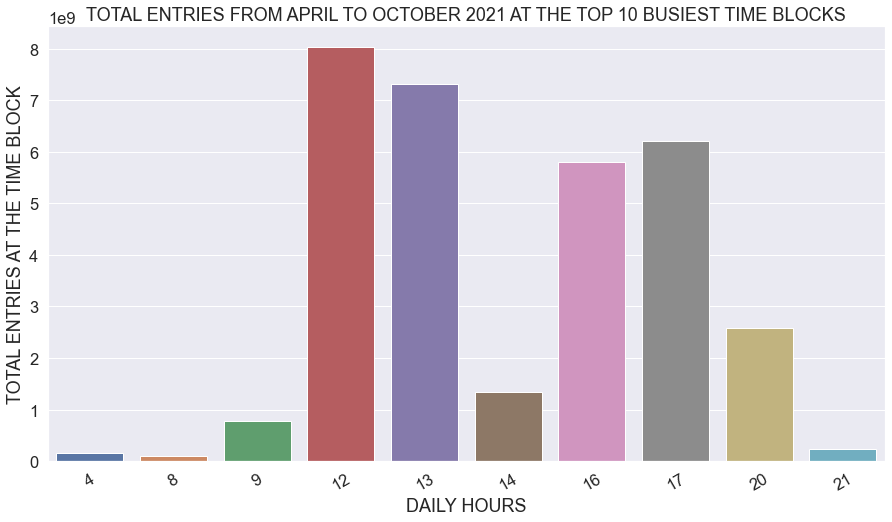

In [56]:
## Plot Results #2
sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale = 1.5)
seaborn_plot = sns.barplot(x=all_moment['HOURS'], y=all_moment['MOMENT_ENTRIES'])
seaborn_plot.set(ylabel = "TOTAL ENTRIES AT THE TIME BLOCK")
seaborn_plot.set(xlabel = "DAILY HOURS")
seaborn_plot.set_title("TOTAL ENTRIES FROM APRIL TO OCTOBER 2021 AT THE TOP 10 BUSIEST TIME BLOCKS")
seaborn_plot.set_xticklabels(seaborn_plot.get_xticklabels(),rotation = 30)
#plt.plot(all_moment['TIME'],all_moment['MOMENT_ENTRIES'])

In [57]:
fig2 = seaborn_plot.get_figure()
fig2.savefig('/home/yingqing/Documents/Metis bootcamp/MTA_EDA_Project1/plot2.png', bbox_inches='tight')

[Text(0, 0, 'FULTON ST'),
 Text(1, 0, 'AQUEDUCT RACETR'),
 Text(2, 0, 'HUNTS POINT AV'),
 Text(3, 0, '161/YANKEE STAD'),
 Text(4, 0, 'HEWES ST'),
 Text(5, 0, 'CANARSIE-ROCKAW'),
 Text(6, 0, 'KINGS HWY'),
 Text(7, 0, 'FLATBUSH AV-B.C'),
 Text(8, 0, '90 ST-ELMHURST'),
 Text(9, 0, '59 ST')]

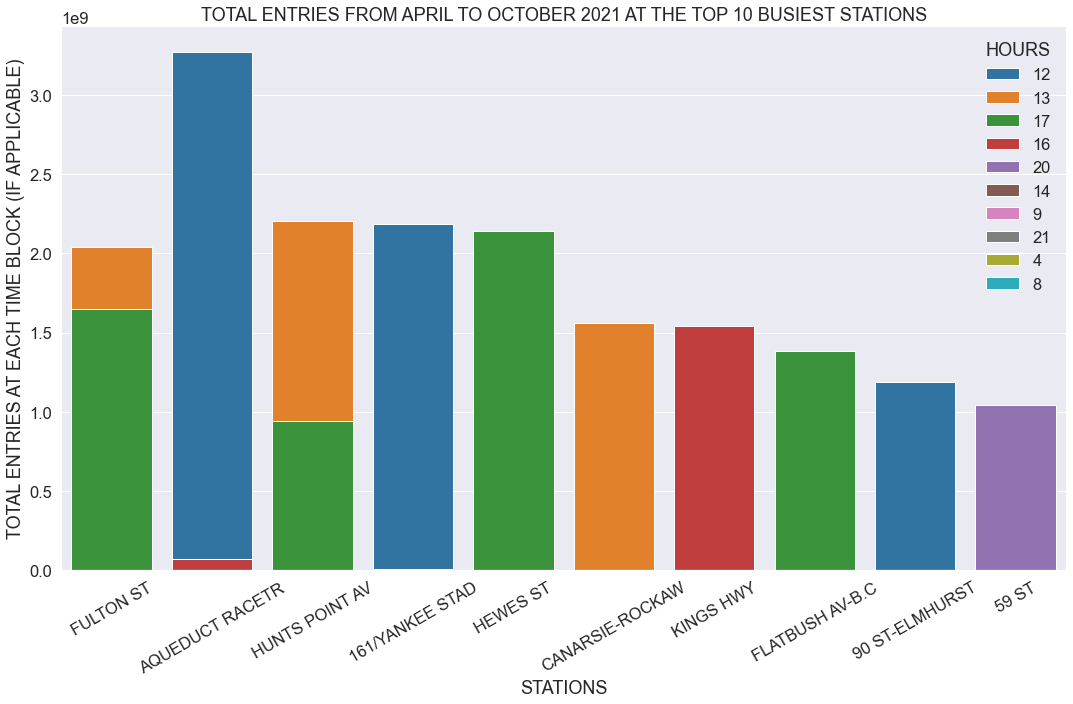

In [77]:
## Plot Results #3
import matplotlib.patches as mpatches
sns.set(rc = {'figure.figsize':(18,10)})
sns.set(font_scale = 1.5)
five_colors = sns.color_palette("tab10")
for i in range(10):
    seaborn_plot = sns.barplot(x=time_df['STATION_NAME'], y=time_df[total_moment.HOURS[i]], color = five_colors[i],\
                               label = total_moment.HOURS[i])

plt.legend(title = "HOURS",frameon=False)
    
seaborn_plot.set(ylabel = "TOTAL ENTRIES AT EACH TIME BLOCK (IF APPLICABLE)")
seaborn_plot.set(xlabel = "STATIONS")
seaborn_plot.set_title("TOTAL ENTRIES FROM APRIL TO OCTOBER 2021 AT THE TOP 10 BUSIEST STATIONS")
seaborn_plot.set_xticklabels(seaborn_plot.get_xticklabels(),rotation = 30)

In [78]:
fig = seaborn_plot.get_figure()
fig.savefig('/home/yingqing/Documents/Metis bootcamp/MTA_EDA_Project1/plot3.png', bbox_inches='tight')

[Text(0, 0, 'FULTON ST'),
 Text(1, 0, 'AQUEDUCT RACETR'),
 Text(2, 0, 'HUNTS POINT AV'),
 Text(3, 0, '161/YANKEE STAD'),
 Text(4, 0, 'HEWES ST'),
 Text(5, 0, 'CANARSIE-ROCKAW'),
 Text(6, 0, 'KINGS HWY'),
 Text(7, 0, 'FLATBUSH AV-B.C'),
 Text(8, 0, '90 ST-ELMHURST'),
 Text(9, 0, '59 ST')]

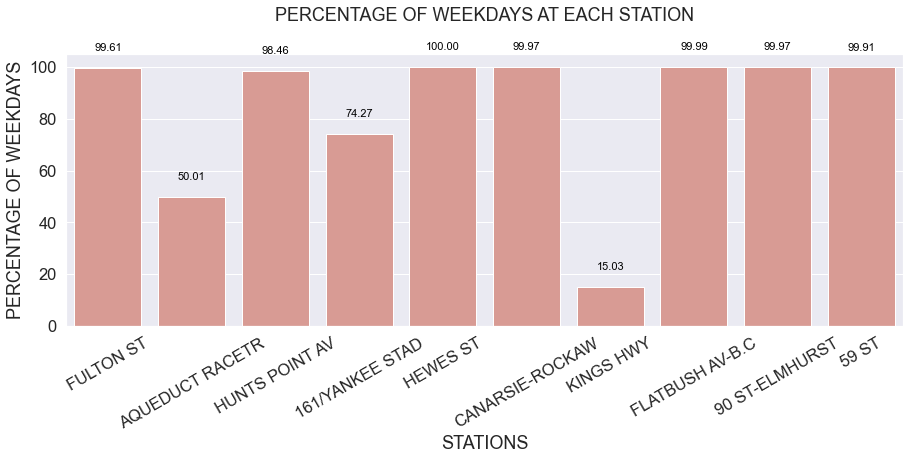

In [179]:
## Plot Results #4
sns.set(rc = {'figure.figsize':(15,5)})
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
seaborn_plot = sns.barplot(x=plot_data4["STATION_NAME"], y=plot_data4["WEEKDAY_RATIO"],ci = float,color="salmon", saturation=.5)
for p in seaborn_plot.patches:
    seaborn_plot.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                textcoords='offset points')    
seaborn_plot.set(ylabel = "PERCENTAGE OF WEEKDAYS")
seaborn_plot.set(xlabel = "STATIONS")
plt.title("PERCENTAGE OF WEEKDAYS AT EACH STATION",y=1.1)
seaborn_plot.set_xticklabels(seaborn_plot.get_xticklabels(),rotation = 30)

In [180]:
fig = seaborn_plot.get_figure()
fig.savefig('/home/yingqing/Documents/Metis bootcamp/MTA_EDA_Project1/plot4.png', bbox_inches='tight')

[Text(0, 0, 'FULTON ST'),
 Text(1, 0, 'AQUEDUCT RACETR'),
 Text(2, 0, 'HUNTS POINT AV'),
 Text(3, 0, '161/YANKEE STAD'),
 Text(4, 0, 'HEWES ST'),
 Text(5, 0, 'CANARSIE-ROCKAW'),
 Text(6, 0, 'KINGS HWY'),
 Text(7, 0, 'FLATBUSH AV-B.C'),
 Text(8, 0, '90 ST-ELMHURST'),
 Text(9, 0, '59 ST')]

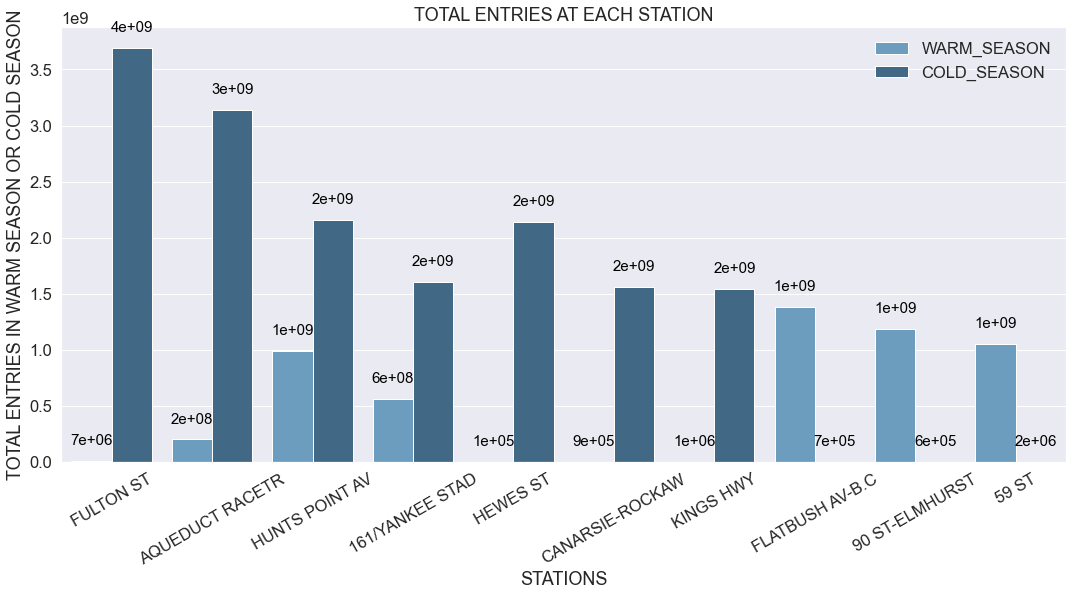

In [181]:
## Plot Results #5
sns.set(rc = {'figure.figsize':(18,8)})
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
five_colors = sns.color_palette("tab10")
seaborn_plot = sns.barplot(data = season_df, x="STATION_NAME", y = "ENTRIES",hue = "SEASON",palette="Blues_d")
plt.legend(frameon=False)
for p in ax.patches:
    seaborn_plot.annotate("%.0e" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=15, color='black', xytext=(0, 20),
                textcoords='offset points')    
seaborn_plot.set(ylabel = "TOTAL ENTRIES IN WARM SEASON OR COLD SEASON")
seaborn_plot.set(xlabel = "STATIONS")
plt.title("TOTAL ENTRIES AT EACH STATION",y=1.0)
seaborn_plot.set_xticklabels(seaborn_plot.get_xticklabels(),rotation = 30)

In [182]:
fig = seaborn_plot.get_figure()
fig.savefig('/home/yingqing/Documents/Metis bootcamp/MTA_EDA_Project1/plot5.png', bbox_inches='tight')